# Evaluation metrics for classification

In [1]:
# Importing the necessary libraries

import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip
!unzip bank.zip

--2024-10-23 11:48:05--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [  <=>               ] 999.85K  2.52MB/s    in 0.4s    

2024-10-23 11:48:06 (2.52 MB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [3]:
# Loading the dataset

df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.columns.str.lower().str.replace(' ', '')

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
columns_to_use = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day',
                  'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[columns_to_use]
#df.head()


In [7]:
df.isnull().sum().sum()

0

In [8]:
df.y = (df.y == 'yes').astype(int)

<ipython-input-8-a17474314ca7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.y = (df.y == 'yes').astype(int)


In [9]:
# Split the data into train and test sets (80% train, 20% test)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split the train data further into train and validation sets (75% train, 25% validation)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [11]:
# Reset the index of the dataframes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Change y variables into an array
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

# Remove/delete the variable from the dataframe
del df_train['y']
del df_val['y']
del df_test['y']

**Question 1: ROC AUC feature importance**  
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.  
- Use the training dataset for that  

If your AUC is < 0.5, invert this variable by putting "-" in front

`(e.g. -df_train['engine_hp'])`

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous

In [12]:
num = df_train.select_dtypes(include=['number']).columns
num

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [13]:
cat = df_train.select_dtypes(include=['object']).columns
cat

Index(['job', 'marital', 'education', 'housing', 'contact', 'month',
       'poutcome'],
      dtype='object')

In [14]:
# ROC AUC feature importance
for feature in num:
    roc_score = roc_auc_score(y_train, df_train[feature])

    # If your AUC is < 0.5, invert this variable by putting "-" in front
    if roc_score < 0.5:
        roc_score = roc_auc_score(y_train, -df_train[feature])
        print(f'The ROC AUC of {feature} (inverted): {roc_score:.3f}')
    else:
        print(f'The ROC AUC of {feature}: {roc_score:.3f}')


The ROC AUC of age (inverted): 0.512
The ROC AUC of balance: 0.589
The ROC AUC of day (inverted): 0.526
The ROC AUC of duration: 0.815
The ROC AUC of campaign (inverted): 0.571
The ROC AUC of pdays: 0.590
The ROC AUC of previous: 0.599


***Duration has the highest AUC***

**Question 2: Training the model**  
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [15]:
df_train.shape, df_val.shape

((27126, 14), (9042, 14))

In [16]:
# Covert the dataframes to a dictionary
train_dicts = df_train.to_dict(orient="records")
val_dicts = df_val.to_dict(orient="records")

# One-hot encoding the datasets with DictVectorizer
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [17]:
X_train.shape, X_val.shape

((27126, 47), (9042, 47))

In [18]:
# Training the logistic regression model
lr_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [19]:
# Making predictions and calculate the ROC AUC on the validation set
y_pred = lr_model.predict_proba(X_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred)
print(f'The ROC AUC on the validation set is: {roc_auc_val:.3f}')

The ROC AUC on the validation set is: 0.900


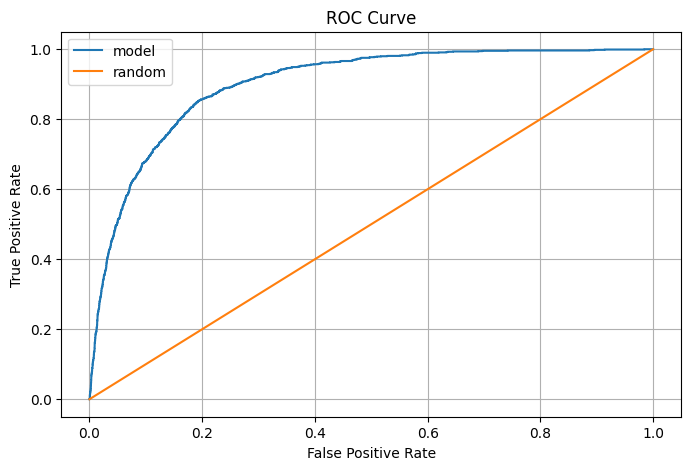

In [20]:
# Ploting the ROC curve
fpr, tpr, threshold = roc_curve(y_val, y_pred)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()

**Question 3: Precision and Recall**  
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them  
At which threshold precision and recall curves intersect?

- 0.265
- 0.465
- 0.665
- 0.865

In [21]:
# Now let's compute precision and recall for our model.
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.linspace(0, 1, 101)
actual_negative = (y_val == 0)
actual_positive = (y_val == 1)

scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    #epsilon = 1e-12
    #precision = tp / (tp + fp + epsilon)
    #recall = tp / (tp + fn + epsilon)


    scores.append((t, precision, recall))

col_names = ['threshold', 'precision', 'recall']
scores_df = pd.DataFrame(scores, columns=col_names)
scores_df.tail()

<ipython-input-21-a3a85b79f4cd>:19: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


,threshold,precision,recall
96,0.96,0.638298,0.027322
97,0.97,0.625000,0.022769
98,0.98,0.677419,0.019126
99,0.99,0.687500,0.010018
100,1.00,NaN,0.000000


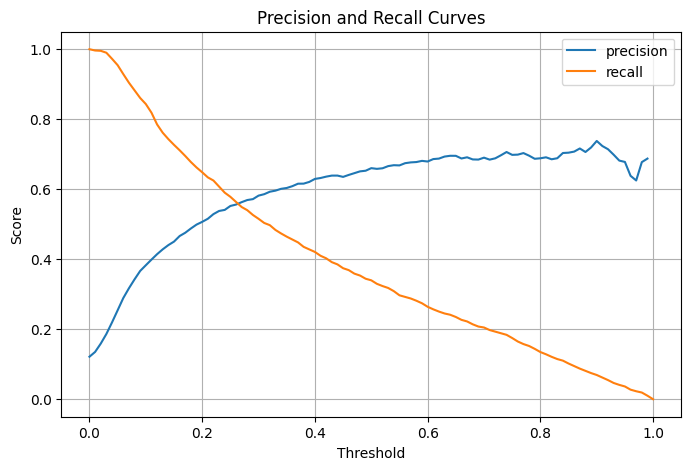

In [22]:
# Ploting the precision and recall curves
plt.figure(figsize=(8,5))

plt.plot(scores_df.threshold, scores_df.precision, label='precision')
plt.plot(scores_df.threshold, scores_df.recall, label='recall')

plt.title('Precision and Recall Curves')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

In [23]:
intersection_threshold = None
min_diff = float('inf')

for i in range(len(thresholds)):
    diff = abs(scores_df.precision[i] - scores_df.recall[i])
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = scores_df.threshold[i]

print(f"The precision and recall curves intersect at approximately threshold: {intersection_threshold:.3f}")

The precision and recall curves intersect at approximately threshold: 0.260


**Question 4: F1 score**   
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F
1
=
2
⋅
P
⋅
R/
P
+
R

Where
P
 is precision and
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [24]:
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
scores_df['f1'] = 2 * scores_df.precision * scores_df.recall / (scores_df.precision + scores_df.recall)
scores_df.tail()

,threshold,precision,recall,f1
96,0.96,0.638298,0.027322,0.052402
97,0.97,0.625000,0.022769,0.043937
98,0.98,0.677419,0.019126,0.037201
99,0.99,0.687500,0.010018,0.019749
100,1.00,NaN,0.000000,NaN


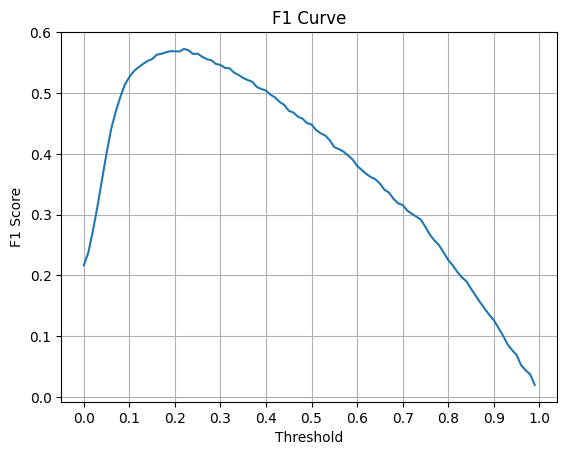

In [25]:
# Ploting the F1 curve
plt.plot(scores_df.threshold, scores_df.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.title('F1 Curve')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [26]:
# At which threshold F1 is maximal?
max_f1_threshold = scores_df.loc[scores_df['f1'].idxmax(), 'threshold']
print(f"The maximum F1 score is achieved at approximately threshold: {max_f1_threshold:.2f}")

The maximum F1 score is achieved at approximately threshold: 0.22


**Question 5: 5-Fold CV**  
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`  
- Iterate over different folds of df_full_train
-Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation  

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [26]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over different folds of df_full_train
df_full_train_copy = df_full_train.copy()

y_full_train = df_full_train.y.values
del df_full_train['y']


In [ ]:
def train_model(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model  

def predict(df, dv, model):
    dicts = df.to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred    

In [ ]:
k_scores = []

for train_idx, val_idx in cv.split(df_full_train):
    # Split the data into train and validation
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    # Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    dv, model = train_model(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    # Use AUC to evaluate the model on validation
    auc = roc_auc_score(y_val, y_pred)
    k_scores.append(auc)

print('%.3f +- %.3f' % (np.mean(k_scores), np.std(k_scores)))

**Question 6: Hyperparameter Tuning**  
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following `C` values:`[0.000001, 0.001, 1]`
- Initialize KFold with the same parameters as previously
- Use these parameters for the model:` LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [ ]:
C = [0.000001, 0.001, 1]
for c in C:
    scores = []
    for train_idx, val_idx in cv.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dv, model = train_model(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    #print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))
    print(f"C={c:4}, {np.mean(scores):.3f} +- {np.std(scores):.3f}")